In [292]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

In [293]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [294]:
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

In [295]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5,1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            
            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    
    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

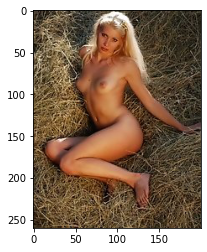

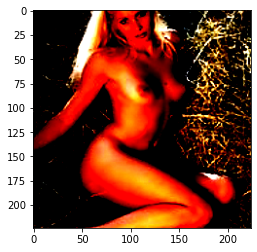

In [296]:
img_file_path = '../data/train/nude/This-Astonishing-Nude-Angel-Decided-To-Loll-About-Just-On-The-Fresh-Hayloft-And-To-Tease-Her-Marvelo.jpg'
img = Image.open(img_file_path)

plt.imshow(img)
plt.show()

resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(resize, mean, std)
img_transformed = transform(img, phase="train")

#(channel, height, width) -> (height, width, channel) - > (0,1)
img_transformed = img_transformed.numpy().transpose(1, 2, 0)
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [297]:
def make_datapath_list(phase="train"):
    rootpath = "../data/"
    target_path = osp.join(rootpath+phase+"/**/*.jpg")

    path_list = []
    
    for path in glob.glob(target_path):
        path_list.append(path)
    
    return path_list

In [298]:
path_list = make_datapath_list("train")

In [299]:
len(path_list)

1694

In [300]:
path_list[0]

'../data/train\\nude\\Blond-girl-Salma-C-shedding-satin-onesie-and-high-heels-to-model-undressed.jpg'

In [301]:
train_list = make_datapath_list("train")
val_list = make_datapath_list("val")

In [310]:
print(len(train_list))

1694


In [302]:
class MyDataset(data.Dataset):
    def __init__(self, file_list, transform=None, phase="train"):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img, self.phase)
        
        if self.phase == "train":
            label = img_path[14:18]
        elif self.phase == "val":
            label = img_path[12:16]
        
        if label == "nude":
            label = 0
        elif label == "sexs":
            label = 1
        
        return img_transformed, label

In [303]:
train_dataset = MyDataset(train_list, transform=ImageTransform(resize, mean, std), phase="train")

In [304]:
val_dataset = MyDataset(val_list, transform=ImageTransform(resize, mean, std), phase="val")

In [305]:
len(val_dataset)

266

In [306]:
index = 0
# print(train_dataset.__len__())
img, label = train_dataset.__getitem__(index)
print(img.shape)
print(label)

torch.Size([3, 224, 224])
0


In [307]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

dataloader_dict = {"train":train_dataloader, "val":val_dataloader}

In [308]:
batch_iterator = iter(dataloader_dict["train"])
inputs, labels = next(batch_iterator)

In [309]:
print(inputs.size()) # inputs.shape
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 0])
